# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [37]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = 'C:/Users/rober/Desktop/'
VIDEO_DIR = 'C:/Users/rober/Desktop/rhAirpuff/videos/'
file_container_obj = FileContainer(ROOT_DIR, VIDEO_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Session folder not found.
  Select .h5 behavior file (i.e. None_None_choice.h5)
  Select directory containing White Matter video files (i.e. None_None)
  Select directory containing SpikeGLX files (i.e. None_None_g0)
Behavior file selected: C:/Users/rober/Desktop/gandalf_20240126/240126_Gandalf_UnityVR.h5
  MonkeyLogic Date: 240126
  MonkeyLogic Monkey: gandalf
Video files directory selected: C:/Users/rober/Desktop/rhAirpuff/videos/240126_Gandalf
  White Matter Video Date: 240126
  White Matter Video Monkey: gandalf
SpikeGLX files directory selected: C:/Users/rober/Desktop/gandalf_20240126/gandalf_20240126_g0
  SpikeGLX Date: 240126
  SpikeGLX Monkey: gandalf



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [38]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 353
Parsing session data...


  0%|          | 0/353 [00:00<?, ?it/s]

  Complete.
    Correct trials: 178
    Errored trials: 175
    Session Length:  02:15:45
Creating Session Objects...
Lick threshold: 0.13 mV
Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...


In [34]:
# from config.add_fields import add_fields
# # save is lick
# # lick is photodiode
# # photodiode is save
# if session_obj.monkey == 'gandalf':
#   session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
#   session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
#   session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
#   session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
#   session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
#   del session_obj.df['cam_sync_2']
#   del session_obj.df['cam_save_2']

#   session_obj.df, session_obj = \
#   add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...
   No novel fractal column found, skipping novel fractal...
   No fractal column found, skipping fractal count...


In [35]:
session_obj.df.head()

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,eye_x,eye_y,eye_pupil,lick,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,Start trial,Frame skipped,Manual reward,End trial,Start,Reward,lick_raster,DEM_raster,trial_bins,trial_in_block,cam_frames
0,231223,0,gandalf,1,1,1,0,1,8,"[9, 10, 18]","[2.1411999769043177, 2869.1711999999825, 50927...","[11.666589723796807, 11.682231055690927, 11.68...","[-8.931953893082216, -8.974025222424308, -8.97...","[7686.0, 7689.0, 7689.0, 7686.0, 7686.0, 7691....","[0.0006632819249543231, -0.0062420898563418925...","[3.313269425058244, 0.0019785908320277823, 0.0...","[0.003622726964232992, 5.627470980623661e-06, ...","[0.7365784810797286, 0.7378937895911905, 0.701...",0.0000,50932.0000,2023-12-23 17:37:55.099,2023-12-23 17:38:46.031,2,<NA>,<NA>,50927,2869,<NA>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",50929,0,"[1014, 1022, 1030, 1039, 1047, 1055, 1064, 107..."
1,231223,0,gandalf,2,1,1,1,0,0,"[9, 10, 14, 50, 18]","[321.4086000225507, 393.3433000056539, 49357.0...","[2.399624281738673, 2.399624281738673, 2.41261...","[-2.804926380705822, -2.804926380705822, -2.79...","[6762.0, 6762.0, 6776.0, 6776.0, 6772.0, 6772....","[0.07333409733994187, 0.0818836048147118, 0.06...","[3.3191883253110372, 3.3159000473854228, 0.011...","[3.331026125996718, 3.324120742234178, 3.33102...","[1.3393186064801978, 1.3600347165001772, 1.366...",50930.5945,109108.5945,2023-12-23 17:38:46.030,2023-12-23 17:39:44.208,321,<NA>,49357,58092,393,57579,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",58176,1,"[7, 15, 23, 32, 40, 48, 57, 65, 73, 82, 90, 98..."
2,231223,0,gandalf,3,1,1,1,0,0,"[9, 10, 50, 18]","[244.9037999904249, 312.6124999835156, 18548.3...","[8.661172718129903, 8.66114303672074, 8.661143...","[-3.58443580506663, -3.59766080638487, -3.5976...","[5333.0, 5346.0, 5346.0, 5313.0, 5313.0, 5327....","[0.12627527752843404, 0.12693293193021005, 0.1...","[0.000992109151831927, 0.006910999223200209, -...","[3.3214901198699804, 3.3188594975176424, 3.302...","[2.0232791680705384, 2.1071301227975665, 1.996...",109106.5228,128252.5228,2023-12-23 17:39:44.205,2023-12-23 17:40:03.351,244,<NA>,<NA>,19065,312,18548,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19146,2,"[4, 12, 20, 29, 37, 45, 54, 62, 70, 79, 87, 95..."
3,231223,0,gandalf,4,1,1,1,0,0,"[9, 10, 50, 18]","[193.0677999916952, 249.82959998305887, 12814....","[-0.05039526751367949, -0.05039526751367949, -...","[-9.843117814602548, -9.843117814602548, -9.76...","[5579.0, 5579.0, 5596.0, 5596.0, 5589.0, 5589....","[0.0818836048147118, 0.08747366737002274, 0.08...","[3.3234630866420156, 3.332341437198878, 3.3076...","[3.3182018419314097, 3.3172153585534487, 3.335...","[1.5629210717155717, 1.5862678008607307, 1.481...",128252.0063,141663.0063,2023-12-23 17:40:03.351,2023-12-23 17:40:16.762,193,<NA>,<NA>,13330,249,12814,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13411,3,"[8, 16, 24, 33, 41, 49, 58, 66, 74, 83, 91, 99..."
4,231223,0,gandalf,5,1,1,1,0,0,"[9, 10, 50, 18]","[190.61379999038763, 265.7947999832686, 9763.4...","[3.2430152908011887, 3.2430152908011887, 3.217...","[-9.5587140356113, -9.5587140356113, -9.539913...","[5661.0, 5661.0, 5661.0, 5657.0, 5657.0, 5661....","[0.08254125923397926, 0.08023946876537834, 0.0...","[3.3142559084295504, -0.00459795371501151, 0.0...","[3.3356297152173124, 3.316557702969066, 3.3306...","[0.5021247333699185, 0.5083724491291893, 0.497...",141663.0958,152024.0958,2023-12-23 17:40:16.763,2023-12-23 17:40:27.124,190,<NA>,<NA>,10277,265,9763,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10360,4,"[5, 13, 22, 30, 38, 47, 55, 63, 72, 80, 8

In [14]:
import pickle
from config.h5_helper import pickler

dest_path = "/Users/rahimhashim/SynologyDrive/Rahim/aragorn_20240126"
dest_path = os.getcwd()
# dest_path = os.path.dirname(file_container_obj.ml_file_path)

pickler(True, 
        save_path=dest_path, 
        session_df=session_obj.df, 
        monkey_input='gandalf',
        experiment_name='VR',
        error_dict=error_dict, 
        behavioral_code_dict=behavioral_code_dict)

Saving .pickle files to: c:\Users\rober\Desktop\Monkey-Emotions
  Pickling 240126_gandalf_VR_behave.pkl
  Total time to pickle: 1.0195 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [3]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start Trial
  Fixation On
  CS On
  Trace Start
  Outcome Start
  End Trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: C:\Users\rober\Desktop\aragorn_20240205\aragorn_20240205_g0\aragorn_20240205_g0_t0.nidq.bin
File Name: D://aragorn_20240205_g0/aragorn_20240205_g0_t0.nidq.bin
  Number of Channels: 9
  File Created: 2024-02-05T15:45:13
  File Length: 5048.2905890027805
nChan: 9, nFileSamp: 10096584
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  2000.000559
 Channel [0]: cam_sync
  Max Val: 3345.642
  Min Val: -3.967
 Channel [1]: cam_save
  Max Val: 3355.408
  Min Val: -7.324
 Channel [2]: lick
  Max Val: 5008.85
  Min Val: -12.817
 Channel [3]: photodiode
  Max Val: 2271.729
  Min Val: 606.079
 Channel [4]: empty
 Channel [5]: empty
 Channel [6]: empty
 Channel [7]: empty
 Channel [8]: empty


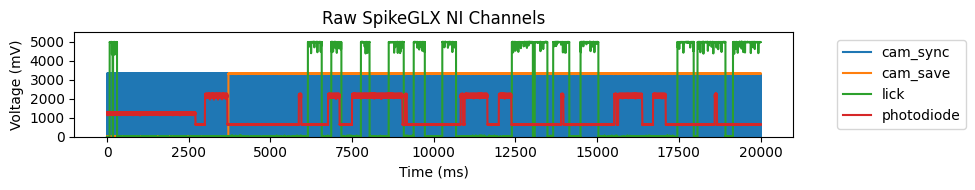

In [6]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)

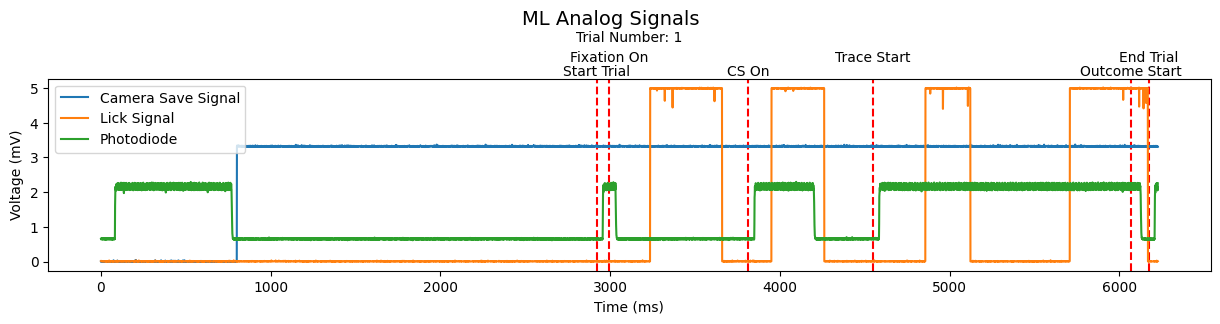

In [5]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

In [ ]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

In [30]:
dir(spikeglx_obj)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cam_save_goes_high',
 '_check_video_paths',
 '_find_SGLX',
 '_find_spikeglx_cam_frames',
 '_get_whitematter_video_paths',
 '_load_spikeglx',
 '_parse_meta_bin',
 'bin_file_path',
 'cam_framenumbers',
 'cam_frames',
 'cam_save',
 'cam_sync',
 'date',
 'lick',
 'meta',
 'ml_sglx_corr_matrix',
 'monkey_name',
 'photodiode',
 'pkl_path',
 'sample_rate',
 'sample_times',
 'save_obj',
 'sglx_file_path',
 'signal_dict',
 'trial_missing_videos',
 'trial_skipping_videos',
 'trial_times',
 'video_file_paths',
 'video_info']

In [31]:
spikeglx_obj.trial_times

defaultdict(<function classes.SpikeGLX.create_float_defaultdict()>,
            {0: defaultdict(float,
                         {'start': 2910.49896263604,
                          'end': 9138.49896263604,
                          'Start Trial': 5831.49896263604,
                          'Fixation On': 5906.49896263604,
                          'CS On': 6724.49896263604,
                          'Trace Start': 7460.49896263604,
                          'Outcome Start': 8977.49896263604,
                          'End Trial': 9085.49896263604}),
             1: defaultdict(float,
                         {'start': 9137.996975251845,
                          'end': 13945.996975251845,
                          'Start Trial': 10857.996975251845,
                          'Fixation On': 10890.996975251845,
                          'CS On': 11601.996975251845,
                          'Trace Start': 12318.996975251845,
                          'Outcome Start': 13831.996975251845,


### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

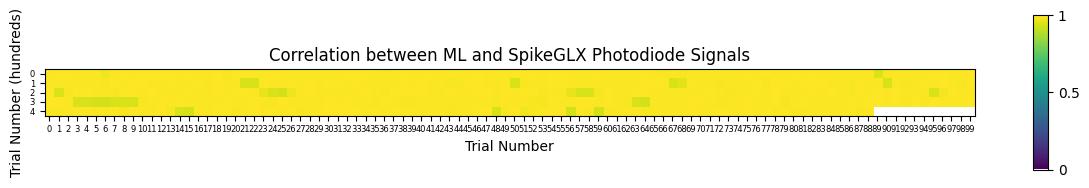

In [8]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [ ]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False,               # 'thread_flag': False
          'exclude_camera': ['e3v83c5']}      # 'exclude_camera': ['e3v83c5']        

parse_wm_videos(**kwargs)

***
## DeepLabCut Pretrained Pose-Assignment

### Manually Assign Cameras

Based on your WhiteMatter camera setup, assign the identifying code of the camera (e3vXXXX) with what it is pointing to in this dictionary. Depending on whether you set the key have `face` or `body` will drive which DLC pretrained model you end up using (`primate_face` vs. `full_macaque`).

In [23]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.7...


In [24]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205
  Number of videos found: 1508


  0%|          | 0/1508 [00:00<?, ?it/s]

  Camera: e3v831b | Number of videos: 377
  Camera: e3v8360 | Number of videos: 377
  Camera: e3v83ad | Number of videos: 377
  Camera: e3v83d6 | Number of videos: 377


In [25]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_2
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\aragorn_240205\\aragorn_240205_0_e3v831b.mp4']
Created "240205_aragorn\body_2-rh-2024-02-06\videos"
Created "240205_aragorn\body_2-rh-2024-02-06\labeled-data"
Created "240205_aragorn\body_2-rh-2024-02-06\training-datasets"
Created "240205_aragorn\body_2-rh-2024-02-06\dlc-models"
Copying the videos
240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_0_e3v831b.mp4
Generated "240205_aragorn\body_2-rh-2024-02-06\config.yaml"

A new project with name body_2-rh-2024-02-06 is created at 240205_aragorn and a configurable file (config.yaml) is stored there. Change the parameters in this file to adapt to your project's needs.
 Once you have changed the configuration file, use the function 'extract_frames' t

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

240205_aragorn\body_2-rh-2024-02-06\dlc-models\iteration-0\body_2Feb6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model 240205_aragorn\body_2-rh-2024-02-06\dlc-models\iteration-0\body_2Feb6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_0_e3v831b.mp4
Loading  240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_0_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:12<00:00, 15.13it/s]


Saving results in 240205_aragorn\body_2-rh-2024-02-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_1
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\aragorn_240205\\aragorn_240205_0_e3v8360.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\labeled-data"
Created "C:\Users\rober\Desktop\Analysis_Pipeline

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\dlc-models\iteration-0\face_1Feb6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\dlc-models\iteration-0\face_1Feb6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\videos\aragorn_240205_0_e3v8360.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\videos\aragorn_240205_0_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:04<00:00, 41.78it/s] 


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_1
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\aragorn_240205\\aragorn_240205_0_e3v83ad.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\dlc-models\iteration-0\body_1Feb6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\dlc-models\iteration-0\body_1Feb6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\videos\aragorn_240205_0_e3v83ad.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\videos\aragorn_240205_0_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 64.78it/s] 


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_2
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\aragorn_240205\\aragorn_240205_0_e3v83d6.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\labele

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\dlc-models\iteration-0\face_2Feb6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\dlc-models\iteration-0\face_2Feb6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\videos\aragorn_240205_0_e3v83d6.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\videos\aragorn_240205_0_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.13it/s] 


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.


In [24]:
# # deeplabcut.refine_labels(config_path_dict['e3v8360'])
# deeplabcut.extract_frames(config_path_dict['e3v8360'], 'automatic')

Config file read successfully.
Do you want to extract (perhaps additional) frames for video: C:\Users\rober\Desktop\Monkey-Emotions\231212_aragorn\face_1-rh-2024-01-08\videos\aragorn_231212_0_e3v8360.mp4 ?
Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1.51  seconds.
Extracting and downsampling... 181  frames from the video.


181it [00:00, 350.18it/s]


Kmeans clustering ... (this might take a while)


### Evaluate Network

TRY THIS TODAY
https://github.com/DeepLabCut/DeepLabCut/blob/main/deeplabcut/generate_training_dataset/frame_extraction.py

In [ ]:
# deeplabcut.evaluate_network(config_path_dict['e3v8360'], 
#                      dlc_video_path_dict['video_path_dict'], 
#                      plotting=True)
# deeplabcut.extract_frames(
#           config_path_dict['e3v8360'],
#           'automatic',
#           'kmeans',
#           'GUI',
#         )

### Run Full Model

In [26]:
# Run DLC
dlc_config.dlc_run(config_path_dict, 
                   dlc_video_path_dict, 
                   start_video=0, 
                   end_video=None, 
                   videotype='mp4', 
                   create_labeled_video=False,
                   session_obj=session_obj)

Attempting to create a symbolic link of the video ...
Video 240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_0_e3v831b.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4 copied to 240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_1_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4 copied to 240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_2_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4 copied to 240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_3_e3v831b.mp4
Symlink creation impossible (exFat arch

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 48.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 92.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 37.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 93.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 92.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 39.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 93.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:01<00:00, 25.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 91.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 45.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 76.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 96.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 99.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 96.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 98.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 44.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 98.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 96.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 82.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 91.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 44.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:01<00:00, 27.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 35.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 90.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 33.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 36.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 43.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 37.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 93.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 79.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 93.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 46.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 96.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 43.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 97.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 48.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 38.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 98.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 37.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 90.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 34.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 96.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 93.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 95.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 97.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 98.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 95.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4
Duration of video [s]:  1.54 , recorded with  120.0 fps!
Overall # of frames:  185  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 185/185 [00:01<00:00, 95.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 45.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 47.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 98.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 99.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 50.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 50.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 49.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 94.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 42.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 97.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 96.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 92.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 95.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 33.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 41.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 98.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 92.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 41.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 34.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 79.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 44.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 87.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 46.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 88.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 77.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 82.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 80.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 88.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 48.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 43.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 88.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 79.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 42.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 32.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 81.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 76.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 82.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 82.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 80.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 78.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 91.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 90.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 79.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 88.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 36.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 44.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 38.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 77.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 42.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 45.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 85.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 79.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 82.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 44.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 79.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 82.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 79.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 75.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 76.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4
Duration of video [s]:  1.54 , recorded with  120.0 fps!
Overall # of frames:  185  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 185/185 [00:02<00:00, 88.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 78.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 46.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 90.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 43.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 42.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 42.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 30.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 39.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 89.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 91.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 34.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 82.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 93.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 47.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 35.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 91.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 44.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 95.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 91.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 95.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 47.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 95.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 45.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 50.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 93.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 48.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 88.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 93.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 46.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 45.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 93.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 44.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 45.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 46.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 47.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:01<00:00, 30.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 47.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 97.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 44.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 47.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 45.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 93.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 91.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 96.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 97.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4
Duration of video [s]:  1.54 , recorded with  120.0 fps!
Overall # of frames:  185  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 185/185 [00:02<00:00, 83.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 91.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 48.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 94.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 42.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 84.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 93.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 43.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 92.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 93.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 73.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 76.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 77.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 80.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 87.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 81.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 84.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 82.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 80.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 86.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 43.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 82.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 78.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 87.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 79.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 80.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 82.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 79.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 76.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 44.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 77.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 75.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 85.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 42.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 32.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 45.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 80.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 81.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 88.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 35.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 43.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 84.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 46.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 40.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 43.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 42.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 82.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 80.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 84.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 77.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 76.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4
Duration of video [s]:  1.54 , recorded with  120.0 fps!
Overall # of frames:  185  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 185/185 [00:02<00:00, 83.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 77.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 33.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 46.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 35.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 43.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 78.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 78.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 41.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 43.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 35.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 76.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 35.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 39.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 88.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 78.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 82.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

In [28]:
for cam in dlc_video_path_dict.keys():
  video_path_list = sorted(dlc_video_path_dict[cam], key=lambda x: int(re.findall(r'(\d+)_{0}'.format(cam), x)[0]))
  config_path = config_path_dict[cam]
  deeplabcut.create_labeled_video(
					config_path, 
					video_path_list, 
					videotype='mp4',
					draw_skeleton=True, 
					filtered=True,
					trailpoints=5,
			)


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 224.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 227.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 219.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 191.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 203.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 208.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 195.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 222.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 217.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 216.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 220.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 195.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 201.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 220.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 249.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 249.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 274.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 246.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 252.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 120.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 181.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 236.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 256.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 257.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 205.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 204.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 213.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 245.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 213.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 219.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 239.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 203.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 209.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 229.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 199.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 248.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 215.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 229.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 253.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 255.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 240.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 246.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 245.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 214.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 256.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 249.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 259.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 255.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 241.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 253.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 191.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 209.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 220.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 194.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 240.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 242.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 219.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 245.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 256.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 264.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 262.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 267.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 240.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 203.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 186.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 239.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 268.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 274.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 239.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 273.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 270.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 219.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 214.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 244.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 234.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 251.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 247.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 248.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 263.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 192.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 242.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 208.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 232.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 228.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 214.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 274.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 223.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 207.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 229.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 274.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 198.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 169.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 219.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 259.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 258.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 184.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 258.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 246.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 258.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 216.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 219.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 256.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 226.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 225.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 236.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 255.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 224.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 231.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 212.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 166.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 212.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 223.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 233.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 269.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 253.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 268.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 248.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 267.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 249.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 264.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 241.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 213.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 262.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 201.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 267.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 212.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 219.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 255.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 231.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 211.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 239.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 239.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 251.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 256.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 237.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 169.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 216.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 270.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 197.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 251.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 242.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 224.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 214.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 202.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 198.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 213.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 224.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 259.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 240.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 241.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 220.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 166.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 191.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 202.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 210.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 169.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 261.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 218.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 239.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 248.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 208.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 234.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 248.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 147.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 218.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 229.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 190.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 248.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 225.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 229.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 265.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 257.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 216.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 234.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 173.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 237.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 249.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 236.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 228.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 227.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 253.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 254.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 214.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 199.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 186.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 251.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 244.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 252.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 203.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 206.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 211.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 226.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 216.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 234.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 246.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 235.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 255.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 210.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 224.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 202.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 228.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 223.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 247.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 250.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 253.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 235.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 189.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 167.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 245.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 242.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 223.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 265.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 243.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 227.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 241.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 204.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 251.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 228.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 212.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 197.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 212.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 226.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 271.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 253.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 240.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:00<00:00, 210.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 222.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 143.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 257.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 245.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 280.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 233.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 225.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 227.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 265.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 228.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 232.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 240.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 236.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 271.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 280.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 240.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 266.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 259.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 263.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 216.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 272.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 247.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 203.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 200.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 205.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 237.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 258.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 260.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 248.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 229.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 278.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 272.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 243.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 198.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 268.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 265.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 271.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 238.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 283.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 242.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 262.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 252.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 209.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 257.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 266.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 262.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 85.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 151.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 230.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 241.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 252.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 255.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 264.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 251.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 259.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 262.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 215.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 248.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 251.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 318.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 290.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 276.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 260.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 288.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 322.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 296.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 310.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 331.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 284.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 284.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 195.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 278.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 254.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 274.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 269.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 196.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 284.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 308.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 289.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 289.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 286.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 245.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 293.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 288.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 248.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 231.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 245.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 232.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 298.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 300.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 240.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 263.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 249.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 249.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 264.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 267.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 293.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 235.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 248.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 178.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 293.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 211.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 251.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 263.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 266.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 226.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 293.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 284.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 306.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 243.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 37.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:05<00:00, 35.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:05<00:00, 35.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 38.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 42.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:05<00:00, 36.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 36.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 40.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 42.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 34.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 39.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 34.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 38.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 37.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:05<00:00, 35.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 41.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 41.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 42.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 43.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 37.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:05<00:00, 36.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 44.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 35.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 42.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 41.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 43.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 38.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 34.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 35.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 35.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 38.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 38.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 44.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 35.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 41.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 35.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 35.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 47.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 40.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 47.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 43.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 43.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 44.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 42.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 38.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 44.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 44.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 46.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 44.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 44.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 40.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 30.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 36.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 35.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 36.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 38.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 30.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 39.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 36.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 38.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 40.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:04<00:00, 40.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 40.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:05<00:00, 33.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:05<00:00, 36.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 36.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:05<00:00, 35.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 39.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 39.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 37.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 36.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 35.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 37.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 39.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 40.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 40.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 41.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 45.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 34.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 40.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 45.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 44.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:03<00:00, 45.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 40.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 38.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:01<00:00, 26.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 43.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 42.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 37.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 43.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 41.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:03<00:00, 45.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 43.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 42.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 41.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 43.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 42.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 40.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 37.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 35.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 40.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 37.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 41.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 37.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:05<00:00, 36.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 39.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 30.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 43.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 46.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 44.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 40.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 43.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 41.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 294.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 268.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 274.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 269.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 295.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 267.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 262.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 247.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 293.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 305.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 282.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 263.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 256.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 133.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 270.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 267.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 272.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 305.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 258.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 304.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 249.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 239.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 277.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 283.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 297.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 217.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 283.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 291.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 290.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 262.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 264.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 282.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 277.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 283.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 271.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 292.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 267.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 292.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 189.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 298.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 260.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 252.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 286.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 285.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 285.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 299.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 280.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 265.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 208.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 259.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 267.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 293.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 289.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 278.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 222.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 195.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 268.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 293.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 273.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 333.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 284.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 315.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 298.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 256.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 260.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 203.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 305.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 281.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 300.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 207.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 285.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 300.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 299.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 257.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 306.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 302.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 313.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 310.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 314.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 300.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 296.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 308.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 315.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 265.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 331.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 318.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 286.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 273.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 197.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 273.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 287.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 311.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 301.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 297.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 294.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 303.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 325.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 322.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 303.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 279.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 308.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 292.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 304.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 311.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 310.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 306.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 315.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 260.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 282.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 273.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 204.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 301.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 276.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 227.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 262.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 291.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 319.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 270.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 305.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 296.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 215.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 311.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 303.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 294.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 325.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 238.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 261.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 308.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 282.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 279.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 294.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 280.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 312.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 309.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 297.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 280.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 258.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 288.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 284.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 190.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 282.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 291.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 300.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 309.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 306.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 310.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 302.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 323.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 292.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 244.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 308.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 292.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 321.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 303.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 281.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 277.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 283.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 296.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 323.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 242.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 268.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 263.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 182.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 224.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 308.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 316.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 280.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 302.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 263.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 308.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 297.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 262.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 325.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 293.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 299.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 312.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 276.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 288.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 332.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 322.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 292.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 299.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 278.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 273.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 259.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 306.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 311.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 194.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 288.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 285.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 296.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 295.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 311.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 311.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 253.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 289.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 316.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 294.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 265.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 321.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 285.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 279.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 258.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 303.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 274.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 286.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 291.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 281.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 207.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 291.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 304.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 307.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 307.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 317.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 320.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:00<00:00, 280.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 267.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 300.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 301.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 322.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 276.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 284.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 261.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 299.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 300.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 271.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 221.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 295.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 283.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 278.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 302.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 312.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 296.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 217.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 305.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 221.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 296.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 303.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 297.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 296.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 322.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 287.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 256.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 296.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 293.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 277.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 217.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 275.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 187.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 251.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 281.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 317.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 273.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 309.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 268.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 270.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 267.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 287.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 293.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 295.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 268.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 275.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 288.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 223.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 282.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 308.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 275.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 299.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 293.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 260.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 278.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 273.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 250.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 269.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 297.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 281.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 248.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 273.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 314.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 316.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 289.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 292.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 303.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 304.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 281.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 276.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 289.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 224.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 293.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 314.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 303.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 287.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 280.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 283.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 208.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 301.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 287.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 305.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 262.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 274.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 272.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 225.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 300.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 281.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 314.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 309.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 304.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 310.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 282.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 275.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 294.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 298.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 264.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 292.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 290.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 283.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 271.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 292.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 299.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 218.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 275.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 207.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 257.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 272.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 271.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 317.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 258.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 274.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 315.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 256.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 269.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 281.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 287.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 291.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 132.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 137.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 118.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 99.49it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 111.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 107.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:02<00:00, 79.80it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 95.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 145.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 122.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 146.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 152.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 109.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 147.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 150.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 117.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 144.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 111.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 130.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 103.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 116.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 157.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 128.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 103.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 96.95it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 131.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 122.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 127.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 106.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 105.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 101.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 94.68it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 119.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 123.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 98.66it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 144.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 103.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 125.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 125.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 99.01it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 141.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 104.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 136.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 115.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 115.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 114.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 110.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 113.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 138.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 122.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 90.07it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 91.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 136.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 134.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 168.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 175.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 97.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 97.47it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.76it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 113.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 97.21it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 179.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 93.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 126.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.66it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 152.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 148.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 99.87it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 151.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 125.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 155.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 100.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 127.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 92.27it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 107.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 129.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 88.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 94.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:02<00:00, 83.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 105.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 166.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 132.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 106.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 107.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 99.98it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 126.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:02<00:00, 88.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 162.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 114.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 111.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 167.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 90.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 119.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 130.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 113.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 142.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 132.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 94.19it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:02<00:00, 81.21it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 128.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 110.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 129.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:02<00:00, 87.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 93.39it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 144.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 91.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 129.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 57.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 152.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 143.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 96.09it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 131.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 101.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 115.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 140.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 92.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 94.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 159.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:02<00:00, 91.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 107.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 89.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 97.32it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 75.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 149.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 77.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.04it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 96.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 82.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 207.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 121.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 121.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 83.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 91.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 132.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 95.39it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 77.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 108.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 105.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 185.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 89.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 136.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 98.98it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 107.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 110.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 149.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 90.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 125.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 105.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 141.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:02<00:00, 88.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 91.45it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 186.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 127.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 135.53it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 101.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 146.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 104.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 109.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 141.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 115.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 109.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 122.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 87.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 132.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 120.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 110.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 104.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 125.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 123.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 124.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 131.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 126.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 74.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 80.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 95.37it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 96.36it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 120.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 103.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 121.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 109.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 99.92it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 96.72it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 90.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 159.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 165.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 129.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 104.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 140.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 108.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 131.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 224.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 167.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 160.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 167.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 111.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 116.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 111.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 139.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 119.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 90.89it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 105.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 125.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 104.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 101.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 111.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 128.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 138.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 113.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 149.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 194.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 114.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 121.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 118.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 98.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 122.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 113.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 99.58it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 96.25it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 121.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 150.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 150.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 173.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 118.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 157.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 135.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 136.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:01<00:00, 111.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 82.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 160.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 139.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 145.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 124.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 133.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 140.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 141.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 154.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 99.11it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 92.65it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 156.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 147.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 98.83it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 102.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 151.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 89.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 117.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 134.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 134.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 119.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 132.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 85.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 108.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:02<00:00, 80.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 106.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 92.68it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 153.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 90.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 115.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.55it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 182.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 134.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 218.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 125.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 144.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 115.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 95.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 186.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 104.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 138.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 157.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 140.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 111.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 128.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 105.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 95.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 162.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 102.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 145.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:02<00:00, 87.81it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 113.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 181.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 132.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 161.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 80.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 121.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 157.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 128.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 138.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 88.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 121.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 104.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 115.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 95.47it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 106.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 94.41it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 154.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 153.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 119.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 156.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 111.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 166.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 206.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 142.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 149.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 149.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 148.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 143.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 114.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 165.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 98.64it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 131.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 128.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 169.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 111.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:01<00:00, 105.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 158.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 184.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 132.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 150.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 99.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 124.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 144.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 117.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 176.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 101.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 150.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 133.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 111.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 170.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:01<00:00, 151.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 140.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 126.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 117.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 82.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 131.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 108.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 121.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 109.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 118.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:01<00:00, 118.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 88.59it/s] 


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 89.71it/s]


***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, 
                            session_obj, 
                            trial_num_selected, 
                            epoch_start, 
                            epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()